## Historical Decomposition

#### Config

In [1]:
## load some packages
# estimation
from scipy.stats import gaussian_kde
from toolkit.estimation import (
        estimation_G,  # matrix
        historical_decomposition,  # histocial decomposition
    )

# model
from models.hankv2 import HANK
from toolkit.irfs import *

# general
from pandas_datareader.fred import FredReader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cmcrameri

## config
plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
        'figure.titlesize': 'medium',
        'figure.labelsize': 'medium',
        'axes.titlesize': 'medium',
    })
cmap = 'cmc.batlow'
sns.set_palette(sns.color_palette(cmap, n_colors=7))
save = True

#### Solve Model

In [2]:
## intialize model
mod_pars = {
        'gamma': 4., 'chi': 2.,  # household parameters, beta and phi are chosen in calibration
        'N_z': 7, 'rho_z': 0.963, 'sigma_z': 0.134,  # household state transitions
        'kappa': 0.1,  # philips curve
        'kappa_W': 0.1,
        'rho_B': 0.93, 'omega_pi': 1.5, 'omega_Y': 0.,  # govt parameters
        'A': 1., 'psi': 1.2, 'psiW': 1.2, 'g': 0.201, 'xi': 1., 'tauP': 1.18, 'eta': 0.081,  # shock steady states
        'epsA': 1., 'epspsi': 1., 'epspsiW': 1., 'epsg': 1., 'epsxi': 1., 'epstauP': 1., 'epseta': 1.,
        'pi': 1., 'B': 0.577,  # variable steady states we define (otherwise model can't be solved)
        'I': 1.005, 'Y': 1.,  # varaible steady states we target
        'N_a': 501, 'a_min': 0, 'a_max': 50,  # grid states
    }
hank = HANK(**mod_pars)

## solve steady state
free = ['beta', 'phi']
endog = ['R', 'G', 'tauL', 'N', 'M', 'D', 'piW', 'L', 'curlN', 'curlC', 'curlB']
markets = {m: HANK.markets[m] for m in ['mkt3', 'mkt4']}  # the other markets clear by definition or by an analytic form
V_a0 = (hank.a_grid[:, None] * (hank.I - 1) + hank.z_grid)**(-hank.gamma)
X0 = np.array([0.9, 0.1])
hank.solve_ss(free, endog, V_a0, X0, markets=markets)
assert np.isclose(hank.curlC + hank.G - hank.Y, 0)  # walras

## solve for perturbation matrix
T = 500
G, dxs = hank.solve_G(T, ha=True, h=1e-4)

f'phi = {hank.phi}; beta = {hank.beta}'

'phi = 3.1554601309064183; beta = 0.944885031287334'

#### Estimates
Plug in the estimates we found earlier

In [3]:
## run instead of estiation, loads from file
res_df = pd.read_csv('data/bayes_results.csv', index_col=0)
shock_pars = res_df['mean'].to_dict()  # save the means to a dictaionary
rhos = {p.split('_')[1]: v for p, v in shock_pars.items() if p.startswith('rho')}
sigmas = {p.split('_')[1]: v for p, v in shock_pars.items() if p.startswith('sigma')}

#### Data
Multiply it by the steady state values bc the model works in real, not %, terms.

In [4]:
## read data, creates in make_data.ipynb
df = pd.read_csv('data/data.csv')

# make it levels of model values
df['t'] = pd.to_datetime(df['t'])
df['Y'] *= hank.Y
df['C'] *= hank.curlC
df['G'] *= hank.G
df['B'] *= hank.B
df['W'] *= hank.W
df['N'] *= hank.N
df['pi'] *= hank.pi
df['I'] *= hank.I

#### Historical Decomposition

In [5]:
## get shock paths
outputs= np.array(['Y', 'pi', 'I', 'N', 'B', 'curlC', 'W'])
est_G = estimation_G(hank.Gmat, outputs)
shock_paths, series_paths_ = historical_decomposition(est_G, np.array(list(rhos.values())), df[np.where(outputs == 'curlC', 'C', outputs)].values)
series_paths, decomp_series_paths = sim_shock_path(G, {z: p for p, z in zip(shock_paths, hank.shocks)}, rhos, dxs)

#### Recession Data

In [6]:
## get data
series = {'USRECQM': 'recession'}
df_fred = FredReader(series.keys(), start='1959-01').read().rename(series, axis='columns')
df_fred = df_fred.dropna().reset_index().rename(columns={'DATE': 't'})

# merge
df = df.merge(df_fred, on='t', how='left')

#### Plot Function

In [7]:
labels = {   # keys for labeling
        'epsA': 'TFP', 'epspsi': 'Markup', 'epspsiW': 'Wage Markup', 'epsg': 'Govt. Spending', 'epsxi': 'Mon. Pol.', 'epstauP': 'Tax Prog.', 'epseta': 'Transfers',  # shocks
        'pi': 'Inflation', 'W': 'Wages', 'M': '$M$', 'D': 'Dividends', 'R': 'Real Interest Rate', 'I': 'Interest Rate', 'tauL': 'Tax Level',  # prices
        'curlC': 'Consumption', 'curlB': 'Bonds',  # hh aggs
        'Y': 'Output', 'N': 'Labor', 'B': 'Bonds', 'G': 'Govt. Spending', 'L': 'Labor',  # econ aggs
    }

def moving_average(arr, n):
    cumsum = arr.cumsum(axis=0)
    return (cumsum[n:] - cumsum[:-n]) / n

def plot_historical_decomp(ax, series_path, decomp_series_path, ss, ma_n=1):
    ## setuo
    ax.axhline(0, c='k', lw=1)
    ss = 1 if ss == 0 else ss

    ## recession
    ax.fill_between(df.index, 0, 1, where=df['recession'] > 0, color='lightgray', alpha=0.5, transform=ax.get_xaxis_transform())

    ## bar plots
    bottom_pos = np.zeros_like(series_path)[1 + ma_n:]
    bottom_neg = np.zeros_like(series_path)[1 + ma_n:]
    for z in decomp_series_path:
        path = moving_average(decomp_series_path[z][1:], ma_n) / ss
        zbottom = np.where(path < 0, bottom_neg, bottom_pos)
        ax.bar(x=df.index[1 + ma_n:], height=path, bottom=zbottom, label=labels[z])
        bottom_neg += np.minimum(path, 0)
        bottom_pos += np.maximum(path, 0)
    
    ## series
    ax.plot(df.index[1 + ma_n:], moving_average(series_path[1:], ma_n) / ss, 'k-', lw=1.5)

    ## ticks
    xticks = ax.get_xticks().astype(int)
    xticks = [x for x in xticks if x in df.index[1 + ma_n:]]
    ax.set_xticks(xticks)
    ax.set_xticklabels(df.loc[xticks, 't'].dt.year)

#### Fitted Shocks
Appendix Figure

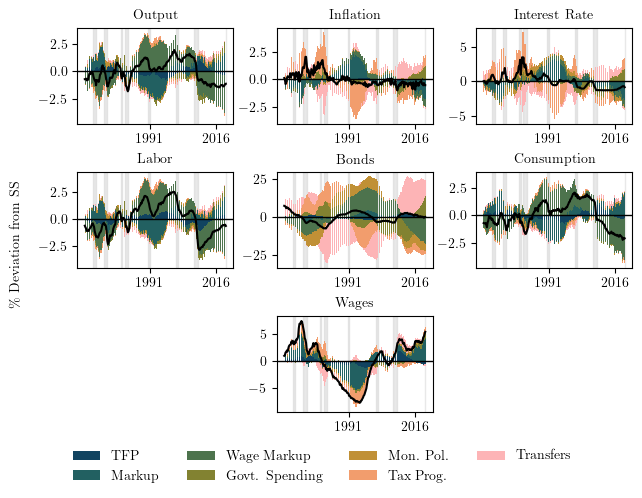

In [8]:
## plot setup
fig, axs = plt.subplots(3, 3)
fig.set_figwidth(6.5)
fig.set_figheight(5)
axs[-1, -3].set_axis_off()
axs[-1, -1].set_axis_off()
axs = np.delete(axs.ravel(), [-3, -1])
fig.supylabel(r'\% Deviation from SS')

# plot each series
for i, X in enumerate(outputs):
    ax = axs[i]
    ax.set_title(labels[X])
    plot_historical_decomp(
            ax,
            series_paths[X],
            {Z: decomp_series_paths[Z][X] for Z in decomp_series_paths},
            hank.__getattribute__(X),
        )

# final things
fig.tight_layout(h_pad=1, w_pad=0.4)
fig.subplots_adjust(bottom=1/6)
fig.legend(*ax.get_legend_handles_labels(), ncol=4, loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False)
if save: fig.savefig('paper/figures/matched_historcial_decomp.pgf')

#### Aggregate Decompositions

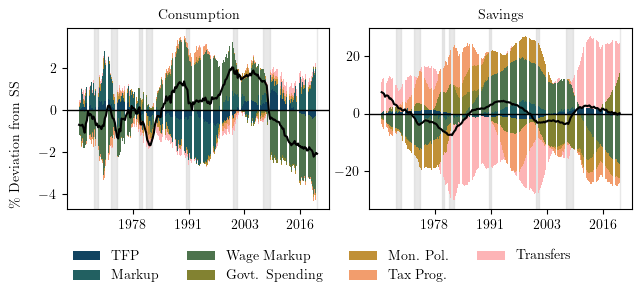

In [9]:
## plot setup
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(6.5)
fig.set_figheight(3)
fig.supylabel(r'\% Deviation from SS')

## plot each series
axs[0].set_title('Consumption')
plot_historical_decomp(
            axs[0],
            series_paths['curlC'],
            {Z: decomp_series_paths[Z]['curlC'] for Z in decomp_series_paths},
            hank.curlC,
        )
axs[1].set_title('Savings')
plot_historical_decomp(
            axs[1],
            series_paths['curlB'],
            {Z: decomp_series_paths[Z]['curlB'] for Z in decomp_series_paths},
            hank.curlB,
        )

# final things
fig.tight_layout(h_pad=1, w_pad=0.4)
fig.subplots_adjust(bottom=2/7)
fig.legend(*axs[0].get_legend_handles_labels(), ncol=4, loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False)
if save: fig.savefig('paper/figures/agg_historical_decomp.pgf')

#### Individual Decompositions

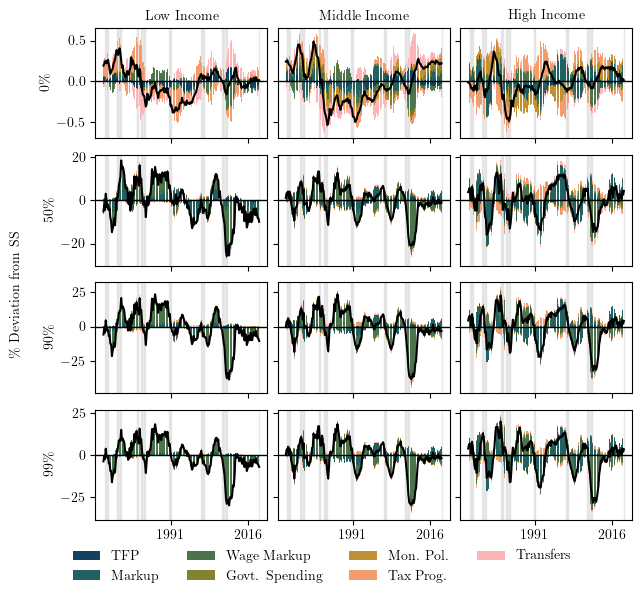

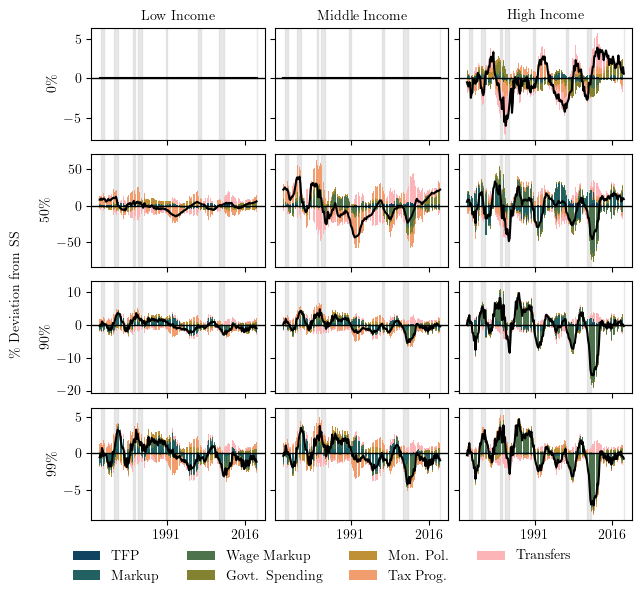

In [10]:
## wage/income levels
pts_a = np.searchsorted(hank.dist.sum(axis=1).cumsum(), [0, 0.5, 0.9, 0.99])  # points on the asset grid, 50th, 90th, 99th percentile
pts_z = np.searchsorted(hank.z_dist.cumsum(), [0.1, 0.5, 0.9])  # points on the productivity grid, 10th, 50th, 90th percentile

## plot setup
for x in ['c', 'a']:
    fig, axs = plt.subplots(4, 3, sharex=True, sharey='row')
    fig.set_figwidth(6.5)
    fig.set_figheight(6)
    fig.supylabel(r'\% Deviation from SS')
    for l, ax in zip(['Low', 'Middle', 'High'], axs[0]):
        ax.set_title(l + ' Income')
    for l, ax in zip(['0', '50', '90', '99'], axs[:, 0]):
        ax.set_ylabel(l + r'\%')

    # plot each series
    for i, a in enumerate(pts_a):
        for j, z in enumerate(pts_z):
            ax = axs[i, j]
            plot_historical_decomp(
                    ax,
                    series_paths[x][a, z],
                    {Z: decomp_series_paths[Z][x][a, z] for Z in decomp_series_paths},
                    hank.__getattribute__(x)[a, z],
                    ma_n=12
                )

    # final things
    fig.tight_layout(h_pad=0.75, w_pad=0.4)
    fig.subplots_adjust(bottom=1/8)
    fig.legend(*ax.get_legend_handles_labels(), ncol=4, loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False)
    if save: fig.savefig(f'paper/figures/{x}_historical_decomp.pgf')

#### Endogenous Decomposition

In [11]:
## get the decomposition
endog_series_paths, endog_decomp_series_paths = decomp_sim_shock_path(G, {z: p for p, z in zip(shock_paths, hank.shocks)}, rhos, hank.int_block_jacs, dxs)

## check my work
for X in endog_series_paths:
    assert np.allclose(endog_series_paths[X] - series_paths[X], 0)

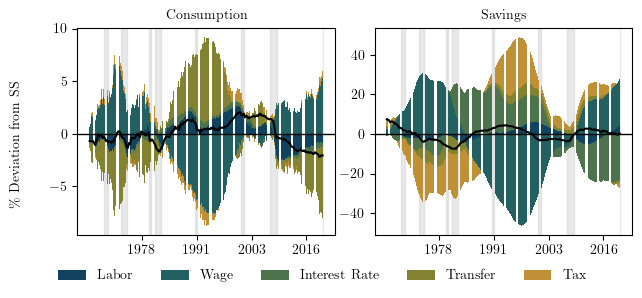

In [12]:
## plot setup
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(6.5)
fig.set_figheight(3)
fig.supylabel(r'\% Deviation from SS')

## setup
labels = {   # keys for labeling
        'L': 'Labor', 'W': 'Wage', 'R': 'Interest Rate', 'T': 'Transfer', 'tau': 'Tax',
    }
keys = {'L': 'L', 'W': 'W', 'R': 'R', 'D': 'T', 'epseta': 'T', 'epstauP': 'tau', 'tauL': 'tau'}
def merge_dict(init_dict):
    final_dict = {}
    for X, irf in init_dict.items():
        add_or_insert(final_dict, keys[X], irf)

    return final_dict


## plot each series
axs[0].set_title('Consumption')
plot_historical_decomp(
            axs[0],
            endog_series_paths['curlC'],
            merge_dict({X: endog_decomp_series_paths['curlC'][X] for X in endog_decomp_series_paths['curlC']}),
            hank.curlC,
        )
axs[1].set_title('Savings')
plot_historical_decomp(
            axs[1],
            endog_series_paths['curlB'],
            merge_dict({X: endog_decomp_series_paths['curlB'][X] for X in endog_decomp_series_paths['curlB']}),
            hank.curlB,
        )

# final things
fig.tight_layout(h_pad=1, w_pad=0.4)
fig.subplots_adjust(bottom=1/5)
fig.legend(*axs[0].get_legend_handles_labels(), ncol=5, loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False)
if save: fig.savefig('paper/figures/endog_agg_historical_decomp.pgf')

#### Seperated

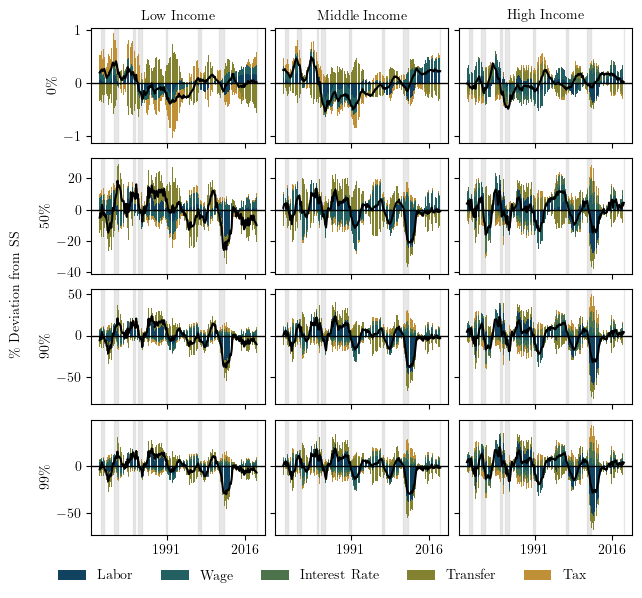

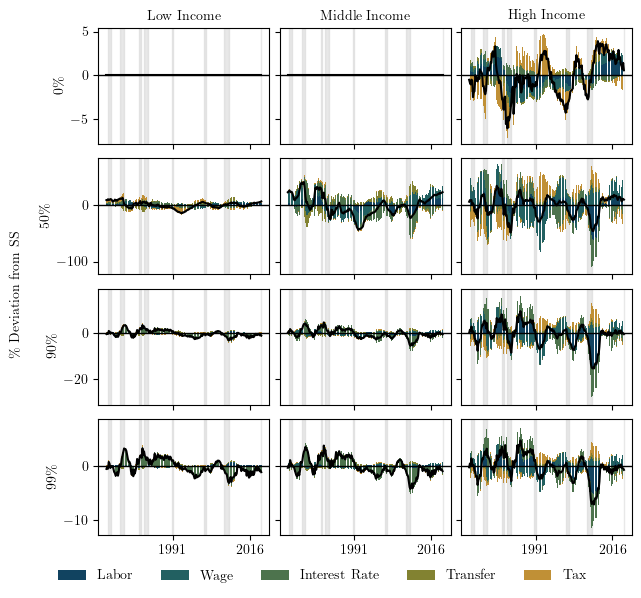

In [13]:
## wage/income levels
pts_a = np.searchsorted(hank.dist.sum(axis=1).cumsum(), [0, 0.5, 0.9, 0.99])  # points on the asset grid, 50th, 90th, 99th percentile
pts_z = np.searchsorted(hank.z_dist.cumsum(), [0.1, 0.5, 0.9])  # points on the productivity grid, 10th, 50th, 90th percentile

## plot setup
for x in ['c', 'a']:
    fig, axs = plt.subplots(4, 3, sharex=True, sharey='row')
    fig.set_figwidth(6.5)
    fig.set_figheight(6)
    fig.supylabel(r'\% Deviation from SS')
    for l, ax in zip(['Low', 'Middle', 'High'], axs[0]):
        ax.set_title(l + ' Income')
    for l, ax in zip(['0', '50', '90', '99'], axs[:, 0]):
        ax.set_ylabel(l + r'\%')

    # plot each series
    for i, a in enumerate(pts_a):
        for j, z in enumerate(pts_z):
            ax = axs[i, j]
            plot_historical_decomp(
                    ax,
                    endog_series_paths[x][a, z],
                    merge_dict({X: endog_decomp_series_paths[x][X][a, z] for X in endog_decomp_series_paths[x]}),
                    hank.__getattribute__(x)[a, z],
                    ma_n=12
                )

    # final things
    fig.tight_layout(h_pad=0.75, w_pad=0.4)
    fig.subplots_adjust(bottom=1/10)
    fig.legend(*ax.get_legend_handles_labels(), ncol=5, loc='lower center', bbox_to_anchor=(0.5, 0), frameon=False)
    if save: fig.savefig(f'paper/figures/endog_{x}_historical_decomp.pgf')
    fig.savefig('check.pdf')